In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Ticker list and parameters
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW'
]
start_date = '2010-01-01'
end_date = '2025-03-31'

In [37]:
def download_stock_data(tickers, start_date, end_date):
    print("Downloading international stock data...")
    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True
    )
    print("Download complete!")
    return data

In [38]:
def preprocess_data(data, tickers, lookback=5, horizon=5):
    processed = {}
    for ticker in tickers:
        if ticker in data:
            df = data[ticker].copy()
            
            # Handle timezone
            if isinstance(df.index, pd.DatetimeIndex):
                df.index = df.index.tz_localize(None)
            
            # Returns and volatility
            df['Return'] = df['Close'].pct_change()
            df['Volatility'] = df['Return'].rolling(21).std()
            
            # Lag features
            for lag in range(1, lookback + 1):
                df[f'Return_lag_{lag}'] = df['Return'].shift(lag)
            
            # Target: future return
            df['Target'] = df['Close'].pct_change(horizon).shift(-horizon)
            
            df = df.dropna()
            if len(df) > 100:
                processed[ticker] = df
    return processed

In [39]:
def random_boost_strategy(data, n_estimators=100, max_depth=8):
    models = {}
    results = []
    
    for ticker, df in data.items():
        print(f"Training {ticker}...")
        
        # Features and target
        features = [col for col in df.columns if col.startswith(('Return', 'Volatility'))]
        X = df[features]
        y = df['Target']
        
        # Train/test split (80/20)
        split = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split], X.iloc[split:]
        y_train, y_test = y.iloc[:split], y.iloc[split:]
        
        # Train Random Forest
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Evaluate
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        # Store results
        models[ticker] = model
        results.append({
            'Ticker': ticker,
            'RMSE': rmse,
            'Feature_Importance': model.feature_importances_
        })
    
    return models, pd.DataFrame(results)

In [40]:
# Download data
raw_data = download_stock_data(tickers, start_date, end_date)

# Preprocess
processed_data = preprocess_data(raw_data, tickers)

# Train models
boost_models, boost_results = random_boost_strategy(processed_data)

[*********************100%***********************]  20 of 20 completed


Download complete!


C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\1404940759.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\1404940759.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Target'] = df['Close'].pct_change(horizon).shift(-horizon)
C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\1404940759.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'f

Training AAPL...
Training MSFT...
Training NVDA...
Training AMZN...
Training GOOGL...
Training META...
Training TSLA...
Training BRK-B...
Training JPM...
Training V...
Training SAP.DE...
Training SIE.DE...
Training ALV.DE...
Training VOW3.DE...
Training LIN.DE...
Training MC.PA...
Training OR.PA...
Training AIR.PA...
Training ASML.AS...
Training NESN.SW...


C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\66761122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=boost_results.sort_values('RMSE'),


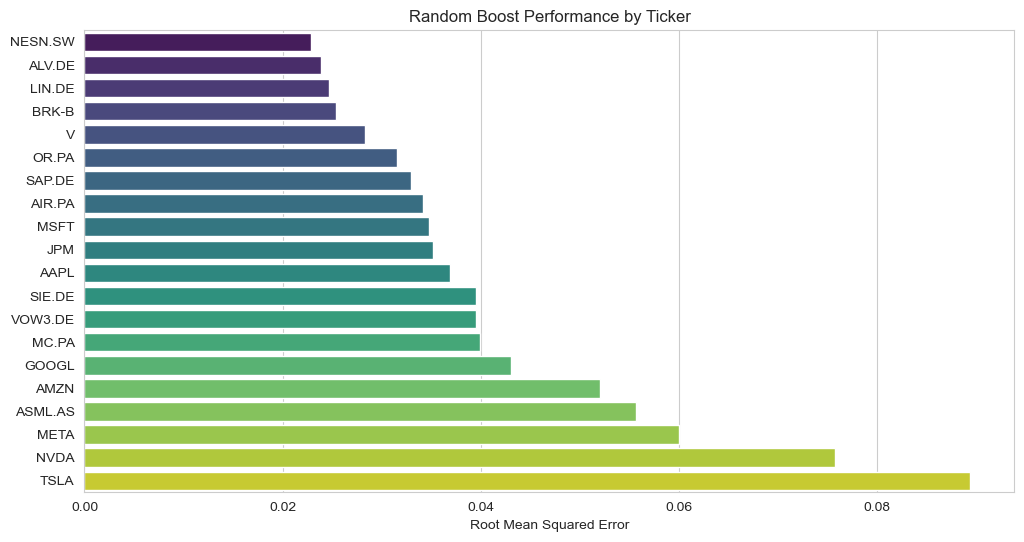

C:\Users\joelt\AppData\Local\Temp\ipykernel_69388\66761122.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='Blues_d')


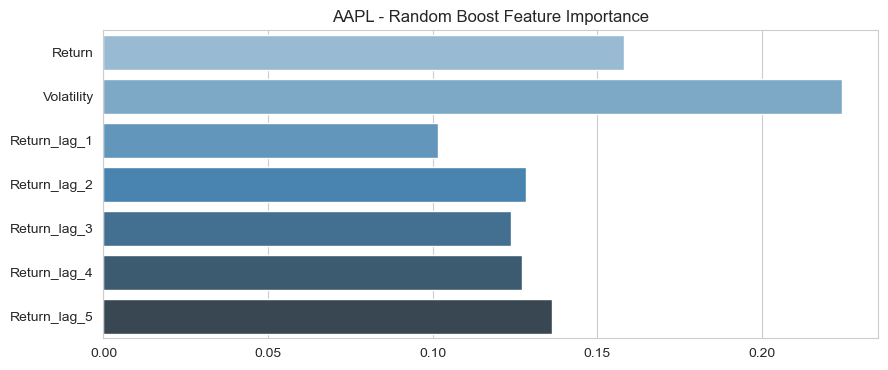

In [41]:
# Performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=boost_results.sort_values('RMSE'), 
            x='RMSE', y='Ticker', palette='viridis')
plt.title('Random Boost Performance by Ticker')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('')
plt.show()

# Feature importance for a sample stock
sample_ticker = 'AAPL'
if sample_ticker in boost_models:
    importance = boost_results.loc[
        boost_results['Ticker'] == sample_ticker, 
        'Feature_Importance'
    ].values[0]
    
    features = [col for col in processed_data[sample_ticker].columns 
               if col.startswith(('Return', 'Volatility'))]
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=importance, y=features, palette='Blues_d')
    plt.title(f'{sample_ticker} - Random Boost Feature Importance')
    plt.show()

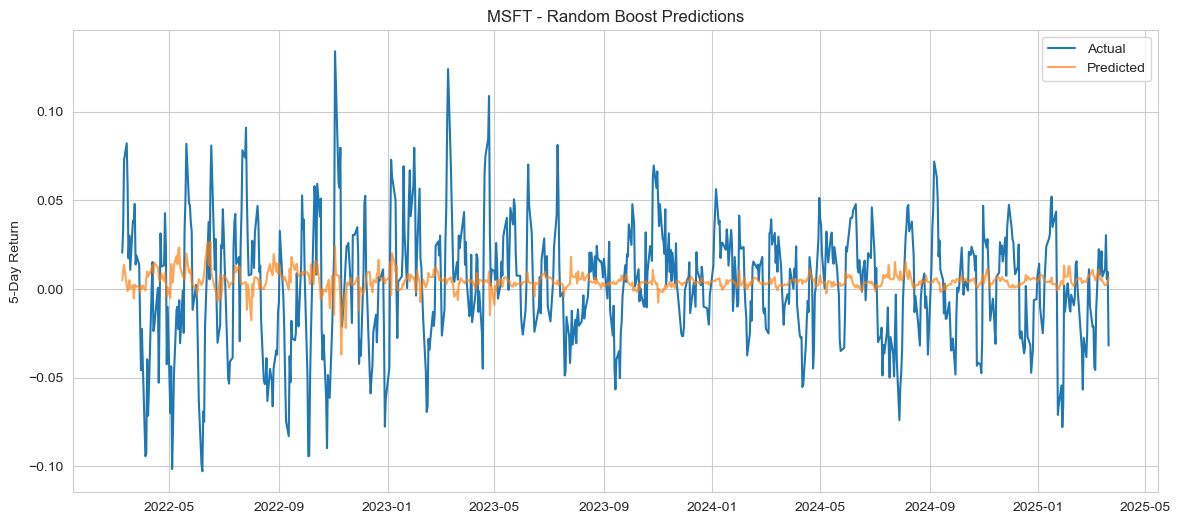

In [42]:
# Actual vs Predicted for a sample stock
sample_ticker = 'MSFT'
if sample_ticker in boost_models:
    df = processed_data[sample_ticker]
    features = [col for col in df.columns if col.startswith(('Return', 'Volatility'))]
    X = df[features]
    
    split = int(len(X) * 0.8)
    predictions = boost_models[sample_ticker].predict(X.iloc[split:])
    
    plt.figure(figsize=(14, 6))
    plt.plot(df.index[split:], df['Target'].iloc[split:], label='Actual')
    plt.plot(df.index[split:], predictions, label='Predicted', alpha=0.7)
    plt.title(f'{sample_ticker} - Random Boost Predictions')
    plt.ylabel('5-Day Return')
    plt.legend()
    plt.grid(True)
    plt.show()